# Introduction
To build sentiment analysis based on dataset from: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [20]:
import pandas as pd
from nltk.book import text1

import utils.regex as rx
import re

## EDA
Let's explore the dataset to understand the features before preparing for building the sentiment prediction models.

In [6]:
# Let's glance at the dataset.
data = pd.read_csv("data/imdb-movie-review-kaggle-laskhmipathi.csv", encoding="ISO-8859-1")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
# The dataset has the following rows and columns.
data.shape

(50000, 2)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [11]:
# Let's investigate if the dataset has missing values.
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [12]:
# Let's investigate the distribution sentiment class distribution.
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

<Axes: xlabel='sentiment'>

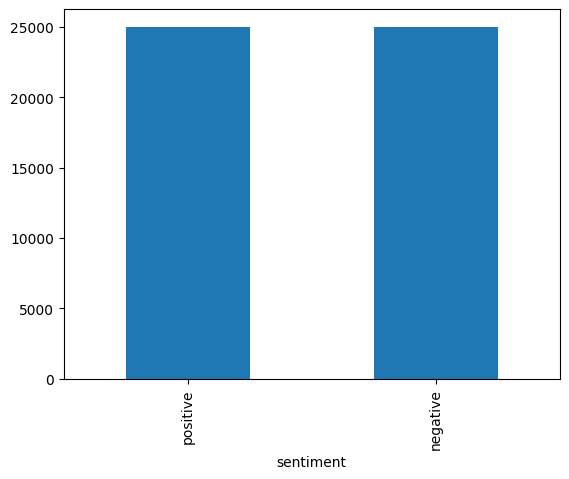

In [14]:
# Looks like the dataset has well-balanced classes for positive and negative sentiment (1:1).
# Let's visualize it in a bar chart.
data['sentiment'].value_counts().plot.bar()

In [53]:
# Let's explore whether if the dataset contains hyperlinks.
temp = []
for index, row in data.iterrows():
    review_text = row['review']
    text_list = re.findall(rx.url_pattern, review_text)
    if len(text_list) > 0:
        temp.append(text_list)

print(f'Dataset contains {len(temp)} number of hyperlinks.')
tmp = pd.Series(temp)
tmp.head()

Dataset contains 190 number of hyperlinks.


0    [(www.cei.org, , , , ), (www.cei.org/pdf/5539....
1                   [(http://www.invocus.net, , , , )]
2    [(http://blog.myspace.com/locoformovies, , , , )]
3                   [(www.softfordigging.com, , , , )]
4    [(www.petitiononline.com/19784444/petition.htm...
dtype: object

In [39]:
# Let's explore whether if the dataset contains emojis.
# TODO:

In [ ]:
# Let's explore whether if the numbers and date.
# TODO:

## Preprocessing
Looks, like the dataset has well-balanced classes for building the sentiment analysis.\
In this section, we will prepare the dataset for building the ML models.

In [15]:
# Convert the sentiment classes from categorical to numeric representation.
data["sentiment"] = data["sentiment"].map({"positive": 1, "negative": 0})

In [16]:
# Let's verify the data after conversion.
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
# Let's remove and verify hyperlinks in the dataset.
# TODO:




In [ ]:
# Let's process and verify emojis in the dataset.
# TODO:

In [ ]:
# Let's remove and verify date in the dataset.
# TODO:

In [ ]:
# Let's remove and verify numbers in the dataset.
# TODO: